<a href="https://colab.research.google.com/github/ParagPote/test-1_-MLOPs-B3/blob/main/Copy_of_M2_NB_MiniProject_2_DeepLabV3%2B_Lungs_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project: Lung Segmentation of Chest X-Ray dataset using DeepLabV3+

## Learning Objectives:

At the end of the experiment, you will be able to:

- understand, prepare, and visualize the the dataset containing image and corresponding masked image used for segmentation
- implement DeepLabV3+ architecture
- create a masked image (prediction)

## Introduction

Semantic segmentation is a computer vision task that involves dividing an image into different regions, each of which is labeled with a semantic category. The goal of semantic segmentation is to enable machines to understand the content of an image at a pixel level, by assigning a label to each individual pixel based on the object or region it belongs to.

This technique is widely used in many applications such as self-driving cars, medical image analysis, and object recognition in robotics. It helps to extract meaningful information from images and to understand the relationships between objects and their environment.

The below figure shows how semantic segmentation differs from other algorithms, such as object detection.

<br>
<img src='https://cdn.iisc.talentsprint.com/AIandMLOps/Images/segmentation_vs_other_algos.jpeg' width=700px>
<br><br>

Moreover, in contrast to object detection, which detects and localizes objects within an image, semantic segmentation is more precise and detailed. It provides a much more granular understanding of the content of an image, allowing for more advanced and accurate applications.

## Dataset

*  The Chest X-Ray dataset is made up of images and segmentated mask from two diffrent sources - Shenzhen and Montgomery dataset
*  The CXR_png folder consists of Chest X-Rays and the masks folder has the segmented mask
*  There are 704 images with their masks mapped with each other  

<br>
$\quad$<img src='https://cdn.extras.talentsprint.com/AIandMLOps/Images/semantic_segmentation.png' width=700px>
<br><br>


## Problem Statement

Perfrom the lungs segmentation on Chest X-Ray dataset using DeepLabV3+ model.

## Grading = 10 Points

In [1]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
!unzip -qq LungSegmentation.zip
print("Data Downloaded Successfuly!!")

--2024-05-31 16:42:31--  https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139904834 (133M) [application/zip]
Saving to: ‘LungSegmentation.zip’

LungSegmentation.zi 100%[===================>] 133.42M  10.5MB/s    in 20s     

2024-05-31 16:42:52 (6.73 MB/s) - ‘LungSegmentation.zip’ saved [139904834/139904834]

Data Downloaded Successfuly!!


### Import required packages

In [18]:
import os
import cv2
import numpy as np
from glob import glob
import glob
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **PART-A**

### Data Visualization (1 point)

#### Image Visualization
Visualize one of the Chest X-Ray image and its segmented label image.

Image size:  (512, 512)


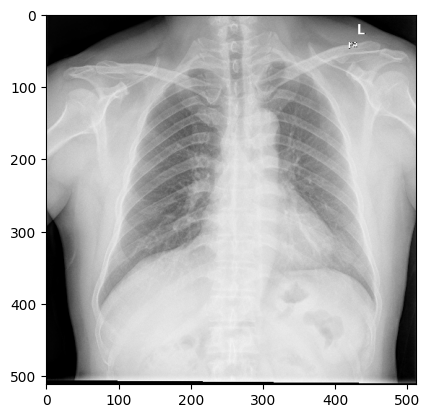

In [12]:
# Visualize an image
# YOUR CODE HERE
image = Image.open('/content/LungSegmentation/CXR_png/CHNCXR_0001_0.png')
image_arr = np.array(image)
plt.imshow(image)
print("Image size: ",image_arr.shape)

Image size:  (512, 512)


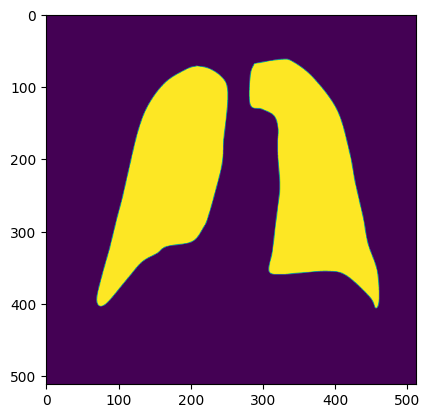

In [13]:
# Visualize a semantic part segmentation label image
# YOUR CODE HERE
image = Image.open('/content/LungSegmentation/masks/CHNCXR_0001_0.png')
image_arr = np.array(image)
plt.imshow(image)
print("Image size: ",image_arr.shape)

### Create a TensorFlow Dataset (1 points)
Use the image size, batch size, number of classes, and data directory as given in the below code cell.

Hint:
1. Find all the image files in the CXR_png and masks subdirectory separately. The resulting list should be sorted in ascending order.
2. Create a list of validation image, validation masks, test image, test masks, etc.
3. Create a function that reads an image file and returns a preprocessed image tensor.  

In [32]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 2
DATA_DIR = "./LungSegmentation"

# Find paths for all the image files in the 'CXR_png' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
# all_images = YOUR CODE HERE
all_images = glob.glob("/content/LungSegmentation/CXR_png/*")
all_images.sort()
print("Total No. of images: ",len(all_images))

# Find paths for all the mask files in the 'masks' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
#all_masks = # YOUR CODE HERE
all_masks = glob.glob("/content/LungSegmentation/masks/*")
all_masks.sort()
print("Total No. of masks: ",len(all_masks))

# Create a list of validation image files
#val_images = # YOUR CODE HERE
val_images = all_images[:int(len(all_images) * 0.1)]
print("Total No. of validation images: ",len(val_images))

# Create a list of validation mask files
#val_masks = # YOUR CODE HERE
val_masks = all_masks[:int(len(all_masks) * 0.1)]
print("Total No. of validation masks: ",len(val_masks))

# Create a list of test image files
#test_images = # YOUR CODE HERE
test_images = all_images[:int(len(all_images) * 0.1)]
print("Total No. of test images: ",len(test_images))

# Create a list of test mask files
#test_masks = # YOUR CODE HERE
test_masks = all_masks[:int(len(all_masks) * 0.1)]
print("Total No. of test masks: ",len(test_masks))

# Create a list of train image files
#train_images = # YOUR CODE HERE
train_images = all_images[:int(len(all_images) * 0.8)]
print("Total No. of train images: ",len(train_images))

# Create a list of train mask files
#train_masks = # YOUR CODE HERE
train_masks = all_masks[:int(len(all_masks) * 0.8)]
print("Total No. of train masks: ",len(train_masks))


Total No. of images:  704
Total No. of masks:  704
Total No. of validation images:  70
Total No. of validation masks:  70
Total No. of test images:  70
Total No. of test masks:  70
Total No. of train images:  563
Total No. of train masks:  563


In [49]:
# Function to read an image file and returns a preprocessed image tensor.
# The mask argument is set to False by default, indicating that it is an image file, not a mask file.

def read_image(image_path, mask=False):

    # YOUR CODE HERE ...

    raw = tf.io.read_file(image_path)
    if mask :
      image = tf.image.decode_png(raw, channels=1)
      # the `print` executes during tracing.
      print("Initial shape: ", image.shape)
      image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
      print("Final shape: ", image.shape)
    else:
      image = tf.image.decode_png(raw, channels=3)
      # the `print` executes during tracing.
      print("Initial shape: ", image.shape)
      image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
      print("Final shape: ", image.shape)

    return image # YOUR CODE HERE


Create a **load_data** function that takes in two arguments, **image_list** and **mask_list**, which are lists of file paths to the images and corresponding masks, respectively. It then reads in the image and mask using the **read_image** function defined earlier. The function returns a tuple of **image** and **mask**.

In [50]:
def load_data(image_list, mask_list):

    image = read_image(image_list)
    mask = read_image(mask_list,mask=True)

    return image, mask # YOUR CODE HERE


Create a **data_generator** function that takes in **image_list** and **mask_list** as arguments.

The function should:
- create a **tf.data.Dataset** object from the input data
- map the **load_data** function to each element in the dataset
- convert the dataset into batches of size **BATCH_SIZE**, drop any incomplete batch at the end of the dataset
- return the resulting dataset

In [51]:
# Generate train and validation set

def data_generator(image_list, mask_list):

    # YOUR CODE HERE ...
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

    return dataset # YOUR CODE HERE


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

Initial shape:  (None, None, 3)
Final shape:  (512, 512, 3)
Initial shape:  (None, None, 1)
Final shape:  (512, 512, 1)
Initial shape:  (None, None, 3)
Final shape:  (512, 512, 3)
Initial shape:  (None, None, 1)
Final shape:  (512, 512, 1)


Check the total images for train and validation.

In [55]:
# YOUR CODE HERE
train_dataset_len = len(train_dataset)
print("Total Train batches: ",train_dataset_len)

Total Train batches:  140


Check the number of batches formed in train and validation set.


Train Image batch shape: (4, 512, 512, 3)
Train Mask batch shape: (4, 512, 512, 1)
Val Image batch shape: (4, 512, 512, 3)
Val Mask batch shape: (4, 512, 512, 1)


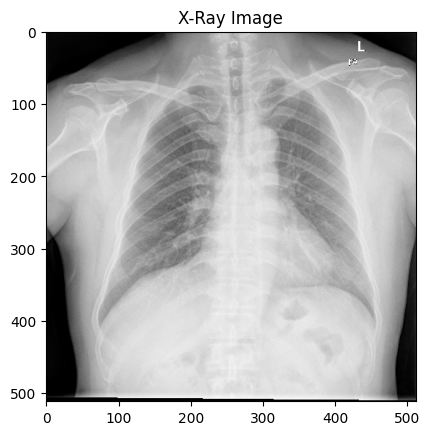

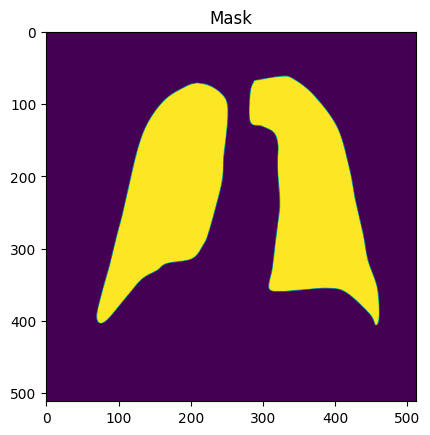

In [76]:
# YOUR CODE HERE
for images, masks in train_dataset.take(1):
    print(f"Train Image batch shape: {images.shape}")
    print(f"Train Mask batch shape: {masks.shape}")
for images, masks in val_dataset.take(1):
    print(f"Val Image batch shape: {images.shape}")
    print(f"Val Mask batch shape: {masks.shape}")

image, label = next(iter(train_dataset))
plt.imshow(image[0])
plt.title("X-Ray Image")
plt.show()
plt.imshow(label[0])
plt.title("Mask")
plt.show()

Now, we have created our TensorFlow Dataset. Further, let us try to understand the DeepLabV3+ model.

### **PART-B**

### Building the DeepLabV3+ model

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation.

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregate context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Dilated_Conv.jpg" width=500px>
<br><br>



#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_model.png" width=1000px>
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EfficientNet.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


### Create the model (5 points)
First, create different functions  to implement DeepLabV3+ architecture.



Create a function, **convolution_block()**, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [ ]:
# YOUR CODE HERE

Create another function to perform **Dilated Spatial Pyramid Pooling**. Use above function to add different convolution blocks.

In [ ]:
# YOUR CODE HERE

The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features from the network backbone that have the same spatial resolution. Here, we use a **ResNet50** pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

##### Exploring ResNet-50 architecture before using it.

In [ ]:
res_input = keras.Input(shape=(128, 128, 3))
resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor = res_input)

# Layers present in ResNet-50 network
resnet50.summary()

From the above layers,

- Use the low-level features from the `conv2_block3_2_relu` layer of the ResNet-50 network to fead in Decoder.

- Use the features from the `conv4_block6_2_relu` layer of the ResNet-50 to fead in Dilated Spatial Pyramid Pooling module.

#### Create Encoder
Create a function to implement the architecture for Encoder block. Use **ResNet50** pretrained on ImageNet as the backbone network. Use the features from the **conv4_block6_2_relu** layer of the backbone to fead in Dilated Spatial Pyramid Pooling module. Then return the backbone network along with encoder output.

In [ ]:
# YOUR CODE HERE

#### Create Decoder

Create a function to implement the architecture for Decoder block. The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features (the **conv2_block3_2_relu** layer) from the network backbone that have the same spatial resolution.

In [ ]:
# YOUR CODE HERE

#### Building full architecture of the Model

Write a function that combines the encoder and decoder functions defined above to create & implement a complete  DeepLabV3+ architecture.

In [ ]:
# YOUR CODE HERE

In [ ]:
# Create model

### Training (1 point)

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

##### Compile model


In [ ]:
# YOUR CODE HERE

##### Model Training

In [ ]:
# YOUR CODE HERE

We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

#####  Learning curve from model history (1 point)

In [ ]:
# Function to plot learning curves
# YOUR CODE HERE

In [ ]:
# Display learning curves
# YOUR CODE HERE

### Visualize Predictions (1 points)

In [ ]:
# Inference from model
# YOUR CODE HERE

#### Plot the predictions

In [ ]:
# YOUR CODE HERE